#import the data and the Modules 

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')
# path = '/content/gdrive/MyDrive/JCE/ysom/End Project/archive'
path = '/content/gdrive/MyDrive/yesom project/archive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
!pip install pytorch_lightning

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import random
import pytorch_lightning as pl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#prepare the data

In [20]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)
pl.seed_everything(seed)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

Global seed set to 0


In [21]:
#import the dataset from the folders
image_datasets = {
    'train': torchvision.datasets.ImageFolder(path+'/walk_or_run_train/train' ,data_transforms['train'] ),
    'val':torchvision.datasets.ImageFolder(path+'/walk_or_run_test/test',data_transforms['val'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 600, 'val': 141}


In [22]:
# init the loader
dataloader = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 4 , shuffle=True , num_workers=0),
    'val':torch.utils.data.DataLoader(image_datasets['val'], batch_size = 4 , shuffle=False , num_workers=0)
}


#Visualize the data

In [23]:
def img_display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  return npimg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

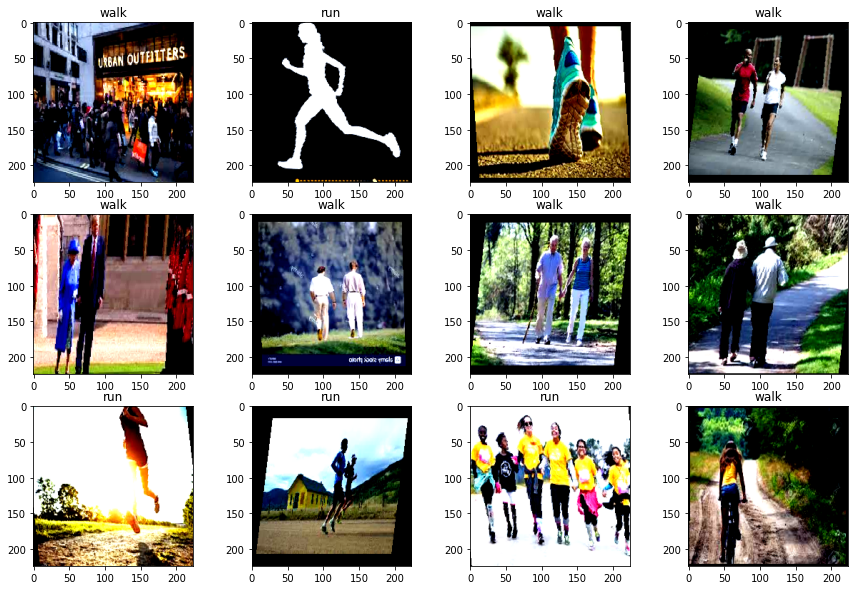

In [24]:
# get some random training images
dataiter = iter(dataloader['train'])
images, labels = dataiter.next()
temp = {0:'run' , 1:'walk'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
  if i % 4 == 0:
    images, labels = dataiter.next()
  with torch.no_grad():
    image, label = images[i%4], labels[i%4]
    ax.imshow(img_display(image)) # add image
    ax.set(title = f"{temp[label.item()]}") # add label

600


<BarContainer object of 2 artists>

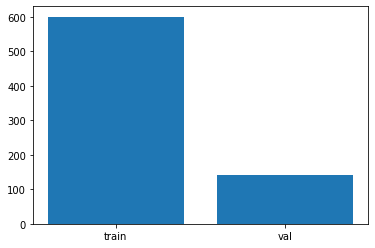

In [25]:
#data size plot
print(dataset_sizes['train'])
plt.bar(*zip(*dataset_sizes.items()))

{'run': 299, 'walk': 301}


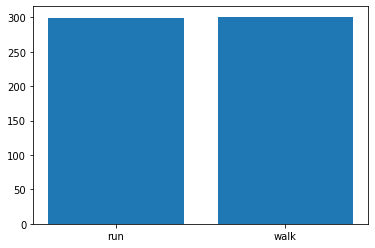

In [26]:
temp_dict ={'run':0 , 'walk':0} 
for x in range(dataset_sizes['train']):
  if image_datasets['train'][x][1] == 0:
    temp_dict['run']+=1
  else:
    temp_dict['walk']+=1
    
plt.bar(*zip(*temp_dict.items()))

print(temp_dict)

#Train class

In [27]:
def train_model (model, criterion, optimizer, scheduler , num_epochs=25 ):
  
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []
  best_predlist = torch.zeros(0,dtype=torch.long, device='cpu')
  best_lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
  for epoch in range(num_epochs):
    
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloader[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for index , i in enumerate(preds):
            if i > 1:
              preds[index] = 1

          loss = criterion(outputs, labels)
          if phase == 'val':
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

          

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()
        epoch_loss = running_loss / dataset_sizes[phase]
        train_loss.append(epoch_loss)
        
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        train_acc.append(epoch_acc)
      else:
        epoch_loss = running_loss / dataset_sizes[phase]
        val_loss.append(epoch_loss)
        
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        val_acc.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_predlist = predlist
        best_lbllist = lbllist

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))


  conf_mat=confusion_matrix(best_lbllist.numpy(), best_predlist.numpy())
  tn = conf_mat[0][0]
  fp = conf_mat[0][1]
  fn = conf_mat[1][0]
  tp = conf_mat[1][1]
  print("tn: {}\nfp: {}\nfn: {}\ntp: {}".format(tn, fp, fn, tp))
  figure, ax = plot_confusion_matrix(conf_mat = conf_mat,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)
  figure.set_size_inches(10, 10)
  fig, axs = plt.subplots(1, 2)
  fig.set_size_inches(25, 10)
  axs[0].plot(train_loss,label='train_loss')
  axs[0].plot(val_loss,label='val_loss')
  axs[0].legend()
  axs[0].set_title('LOSS')
  axs[0].set_yticks(np.arange(0, 1., 0.05))
  
  axs[0].grid()
  axs[1].plot(train_acc,label='train_acc')
  axs[1].plot(val_acc,label='val_acc')
  axs[1].legend()
  axs[1].set_title('ACCURACY')
  axs[1].set_yticks(np.arange(0, 1., 0.05))
  axs[1].grid()
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model , num_epochs, train_loss ,val_loss,train_acc ,val_acc , best_acc , tn, fp, fn, tp

In [29]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloader['val']):
      # print(inputs)
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      plt.figure(figsize=(3, 3))
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far )
        ax.axis('off')
        ax.set_title('predicted: {}'.format(preds[j]))
        plt.gcf().set_size_inches(20, 20)
        ax.imshow(img_display(inputs.cpu().data[j]))
        # print(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
      model.train(mode=was_training)

In [30]:
arr = {}

#0

In [31]:
model180 = models.resnet18(pretrained=True)
num_ftrs = model180.fc.in_features
model180.fc = nn.Linear(num_ftrs , 2)

model180 = model180.to(device)

criterion0 = nn.CrossEntropyLoss()
optimizer0 = optim.SGD(model180.parameters(), lr=0.001)
step_lr_scheduler0 = lr_scheduler.CosineAnnealingLR(optimizer0 , T_max= 10 , eta_min=0)

Epoch 0/49
----------
train Loss: 0.6891 Acc: 0.5817
val Loss: 0.6195 Acc: 0.6667

Epoch 1/49
----------
train Loss: 0.5811 Acc: 0.6983
val Loss: 0.5509 Acc: 0.7234

Epoch 2/49
----------
train Loss: 0.5330 Acc: 0.7483
val Loss: 0.5829 Acc: 0.7163

Epoch 3/49
----------
train Loss: 0.4951 Acc: 0.7633
val Loss: 0.5097 Acc: 0.7447

Epoch 4/49
----------
train Loss: 0.4730 Acc: 0.7867
val Loss: 0.5140 Acc: 0.7518

Epoch 5/49
----------
train Loss: 0.4985 Acc: 0.7600
val Loss: 0.4883 Acc: 0.7801

Epoch 6/49
----------
train Loss: 0.4717 Acc: 0.7700
val Loss: 0.4446 Acc: 0.7872

Epoch 7/49
----------
train Loss: 0.4557 Acc: 0.7933
val Loss: 0.4606 Acc: 0.7943

Epoch 8/49
----------
train Loss: 0.4367 Acc: 0.8150
val Loss: 0.4751 Acc: 0.8014

Epoch 9/49
----------
train Loss: 0.4384 Acc: 0.8133
val Loss: 0.4747 Acc: 0.7943

Epoch 10/49
----------
train Loss: 0.4147 Acc: 0.8067
val Loss: 0.4634 Acc: 0.8156

Epoch 11/49
----------
train Loss: 0.4157 Acc: 0.8167
val Loss: 0.4657 Acc: 0.8085

Ep

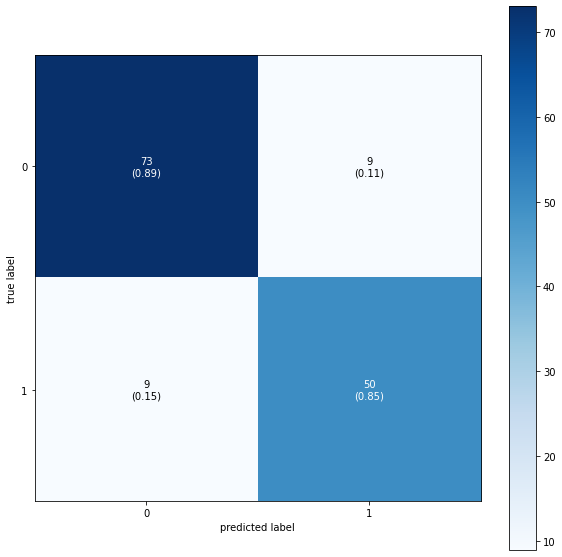

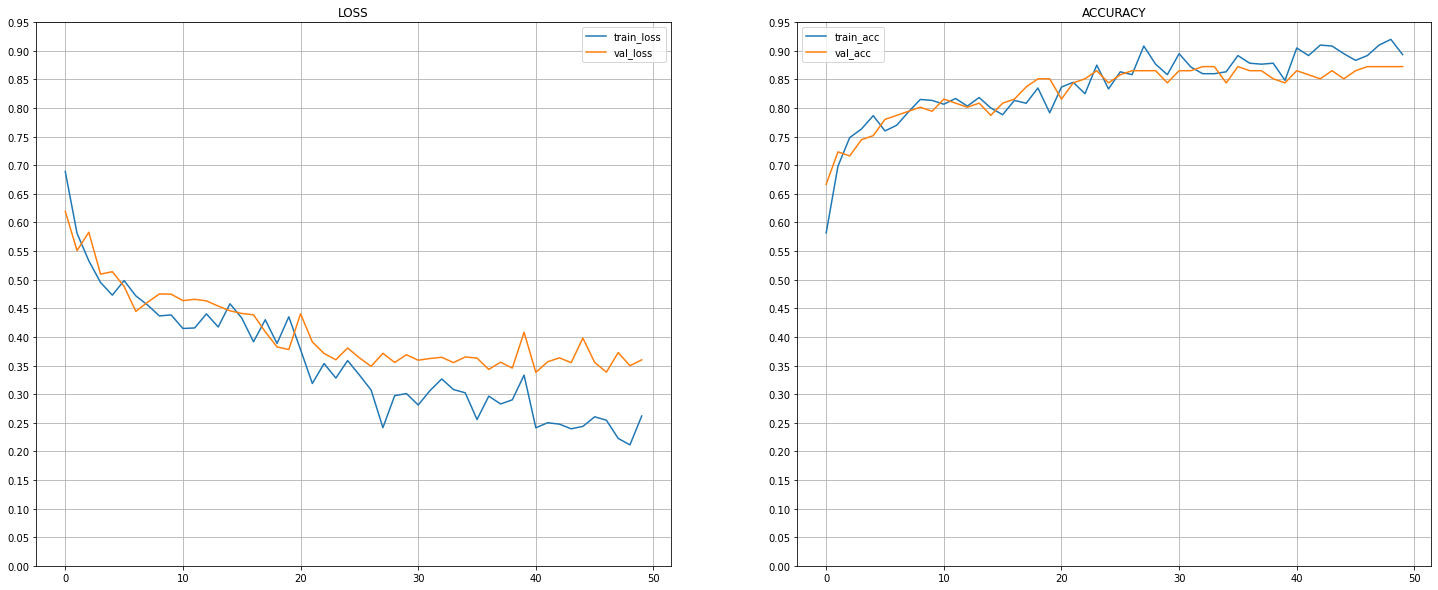

In [32]:
arr['0'] = train_model(model180 , criterion0 , optimizer0 , step_lr_scheduler0 , num_epochs=50)

#1

In [34]:
model181 = models.resnet18(pretrained=True)
num_ftrs = model181.fc.in_features
model181.fc = nn.Linear(num_ftrs , 2)

model181 = model181.to(device)

criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model181.parameters(), lr=0.001)
step_lr_scheduler1 = lr_scheduler.CosineAnnealingLR(optimizer1 , T_max= 10 , eta_min=0)

Epoch 0/49
----------
train Loss: 0.8411 Acc: 0.5250
val Loss: 0.7588 Acc: 0.7092

Epoch 1/49
----------
train Loss: 0.6916 Acc: 0.6017
val Loss: 0.7568 Acc: 0.5745

Epoch 2/49
----------
train Loss: 0.7225 Acc: 0.5600
val Loss: 0.6364 Acc: 0.6454

Epoch 3/49
----------
train Loss: 0.6844 Acc: 0.5933
val Loss: 0.6512 Acc: 0.6667

Epoch 4/49
----------
train Loss: 0.6755 Acc: 0.5950
val Loss: 0.5822 Acc: 0.6879

Epoch 5/49
----------
train Loss: 0.6571 Acc: 0.6367
val Loss: 0.5476 Acc: 0.7163

Epoch 6/49
----------
train Loss: 0.6034 Acc: 0.6750
val Loss: 0.5581 Acc: 0.7447

Epoch 7/49
----------
train Loss: 0.5879 Acc: 0.6783
val Loss: 0.5727 Acc: 0.7021

Epoch 8/49
----------
train Loss: 0.5227 Acc: 0.7533
val Loss: 0.5069 Acc: 0.7660

Epoch 9/49
----------
train Loss: 0.5384 Acc: 0.7433
val Loss: 0.5177 Acc: 0.7589

Epoch 10/49
----------
train Loss: 0.5280 Acc: 0.7417
val Loss: 0.5251 Acc: 0.7589

Epoch 11/49
----------
train Loss: 0.5058 Acc: 0.7583
val Loss: 0.5214 Acc: 0.7518

Ep

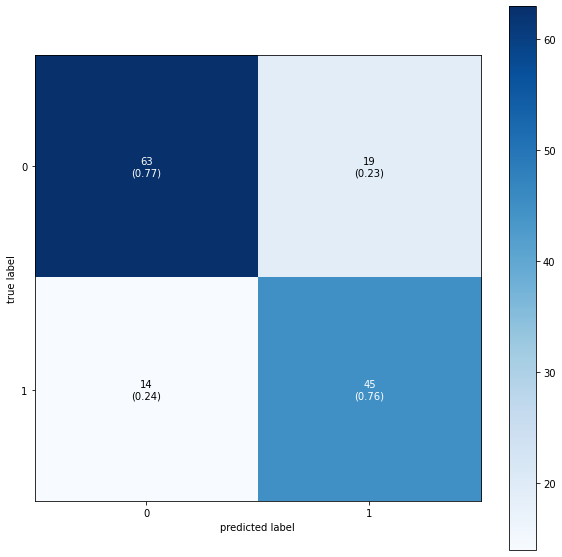

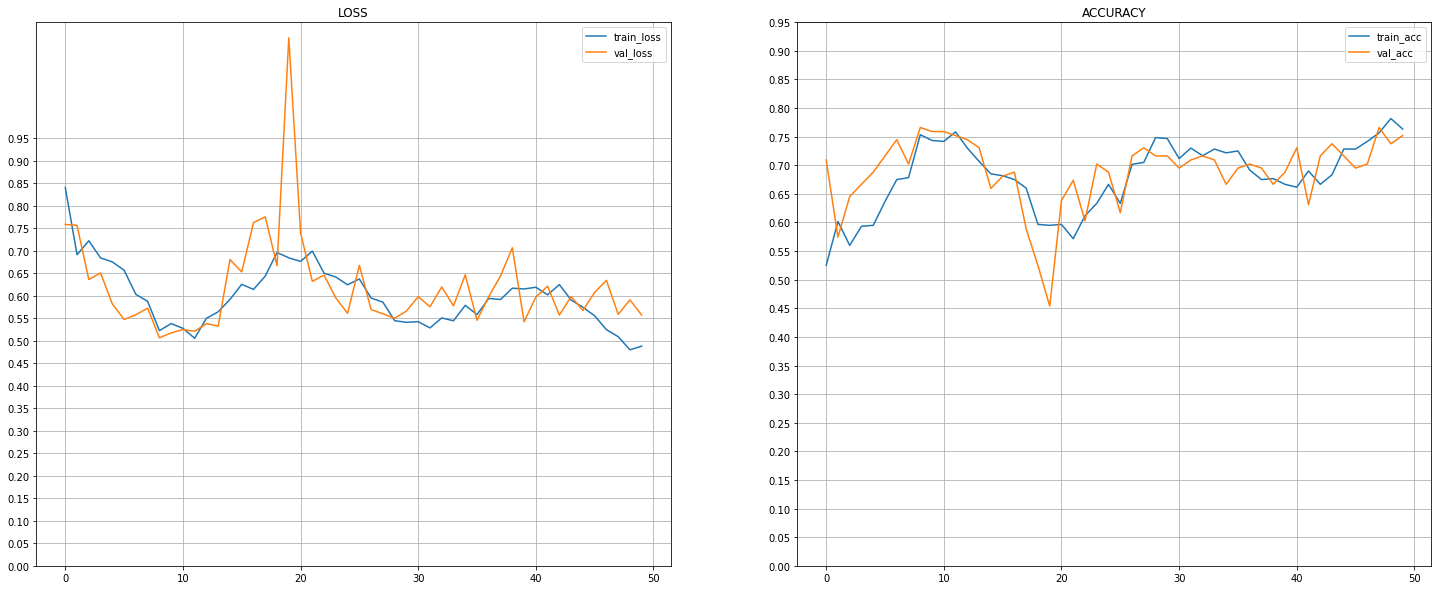

In [35]:
arr['1'] = train_model(model181 , criterion1 , optimizer1 , step_lr_scheduler1 , num_epochs=50)

#2

In [36]:
model182 = models.resnet18(pretrained=True)
num_ftrs = model182.fc.in_features
model182.fc = nn.Linear(num_ftrs , 2) 

model182 = model182.to(device)

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(model182.parameters(), lr=0.001)
step_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

Epoch 0/49
----------
train Loss: 0.6760 Acc: 0.5917
val Loss: 0.6449 Acc: 0.6454

Epoch 1/49
----------
train Loss: 0.5974 Acc: 0.6917
val Loss: 0.5843 Acc: 0.6879

Epoch 2/49
----------
train Loss: 0.5553 Acc: 0.7217
val Loss: 0.5245 Acc: 0.7234

Epoch 3/49
----------
train Loss: 0.5247 Acc: 0.7583
val Loss: 0.4973 Acc: 0.7518

Epoch 4/49
----------
train Loss: 0.5096 Acc: 0.7567
val Loss: 0.4648 Acc: 0.7730

Epoch 5/49
----------
train Loss: 0.4743 Acc: 0.7700
val Loss: 0.4675 Acc: 0.7660

Epoch 6/49
----------
train Loss: 0.4395 Acc: 0.7933
val Loss: 0.4268 Acc: 0.7872

Epoch 7/49
----------
train Loss: 0.4041 Acc: 0.8150
val Loss: 0.4339 Acc: 0.7872

Epoch 8/49
----------
train Loss: 0.4333 Acc: 0.8267
val Loss: 0.4167 Acc: 0.7943

Epoch 9/49
----------
train Loss: 0.3671 Acc: 0.8417
val Loss: 0.4365 Acc: 0.7943

Epoch 10/49
----------
train Loss: 0.3964 Acc: 0.8083
val Loss: 0.4145 Acc: 0.7943

Epoch 11/49
----------
train Loss: 0.4013 Acc: 0.8450
val Loss: 0.4138 Acc: 0.7872

Ep

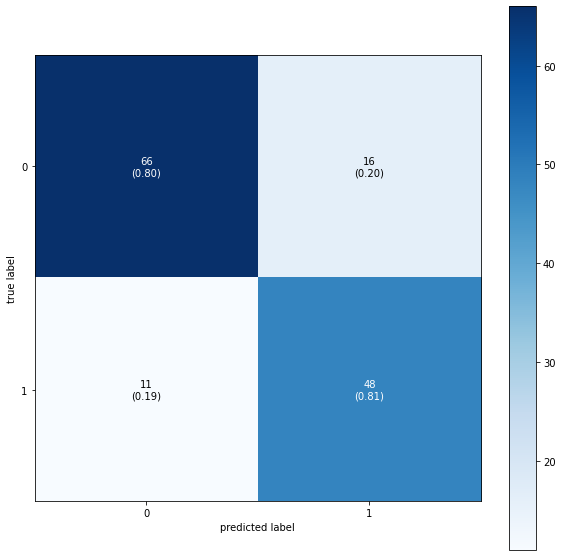

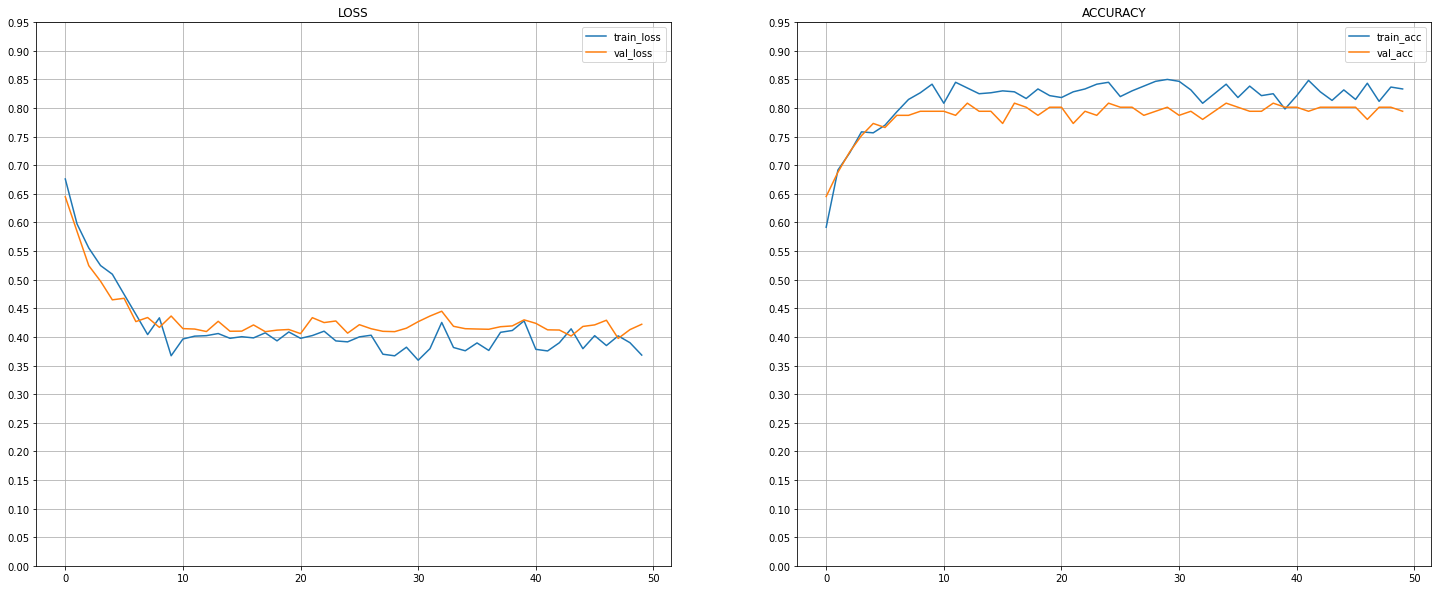

In [37]:
arr['2'] = train_model(model182 , criterion2 , optimizer2 , step_lr_scheduler2 , num_epochs=50)

#3

In [38]:
model183 = models.resnet18(pretrained=True)
num_ftrs = model183.fc.in_features
model183.fc = nn.Linear(num_ftrs , 2) 

model183 = model183.to(device)

criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.SGD(model183.parameters(), lr=0.001)
step_lr_scheduler3 = lr_scheduler.CosineAnnealingLR(optimizer3 , T_max= 10 , eta_min=0)

Epoch 0/99
----------
train Loss: 0.6825 Acc: 0.5817
val Loss: 0.6269 Acc: 0.6312

Epoch 1/99
----------
train Loss: 0.6157 Acc: 0.6567
val Loss: 0.5529 Acc: 0.7376

Epoch 2/99
----------
train Loss: 0.5520 Acc: 0.7217
val Loss: 0.5287 Acc: 0.7163

Epoch 3/99
----------
train Loss: 0.5348 Acc: 0.7350
val Loss: 0.4863 Acc: 0.7589

Epoch 4/99
----------
train Loss: 0.5174 Acc: 0.7517
val Loss: 0.4728 Acc: 0.7518

Epoch 5/99
----------
train Loss: 0.4838 Acc: 0.7817
val Loss: 0.4677 Acc: 0.7518

Epoch 6/99
----------
train Loss: 0.4531 Acc: 0.8067
val Loss: 0.4424 Acc: 0.7730

Epoch 7/99
----------
train Loss: 0.4790 Acc: 0.7717
val Loss: 0.4658 Acc: 0.7589

Epoch 8/99
----------
train Loss: 0.4406 Acc: 0.8133
val Loss: 0.4547 Acc: 0.7660

Epoch 9/99
----------
train Loss: 0.4734 Acc: 0.7817
val Loss: 0.4372 Acc: 0.7943

Epoch 10/99
----------
train Loss: 0.4323 Acc: 0.8217
val Loss: 0.4716 Acc: 0.7447

Epoch 11/99
----------
train Loss: 0.4578 Acc: 0.7633
val Loss: 0.4783 Acc: 0.7447

Ep

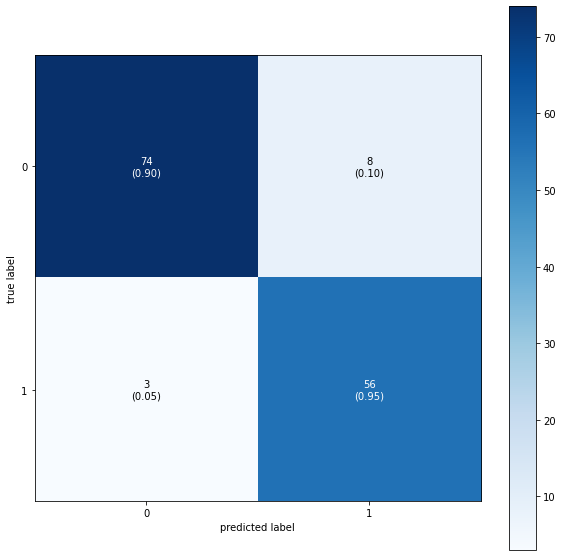

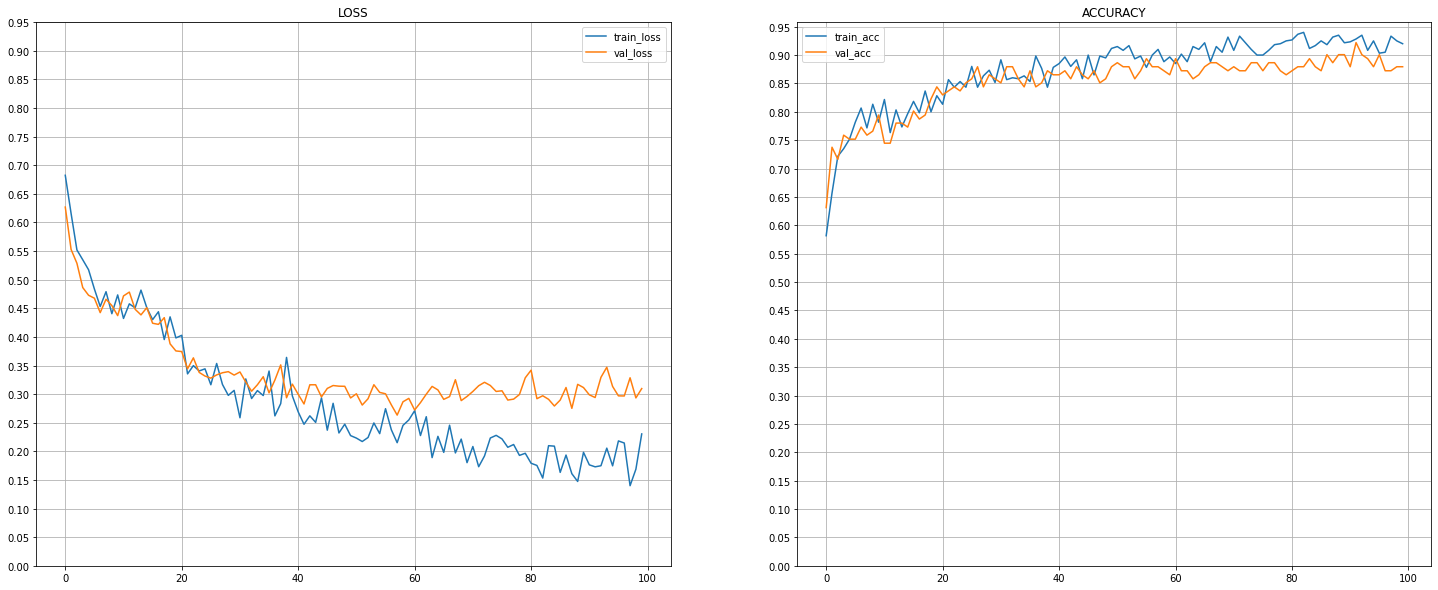

In [39]:
arr['3'] = train_model(model183 , criterion3 , optimizer3 , step_lr_scheduler3 , num_epochs=100)

#4

In [40]:
model504 = models.resnet50(pretrained=True)
num_ftrs = model504.fc.in_features
model504.fc = nn.Linear(num_ftrs , 2) 

model504 = model504.to(device)

criterion4 = nn.CrossEntropyLoss()
optimizer4 = optim.SGD(model504.parameters(), lr=0.001)
step_lr_scheduler4 = lr_scheduler.CosineAnnealingLR(optimizer4 , T_max= 10 , eta_min=0)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/49
----------
train Loss: 0.6772 Acc: 0.5833
val Loss: 0.5859 Acc: 0.7234

Epoch 1/49
----------
train Loss: 0.6158 Acc: 0.6750
val Loss: 0.5534 Acc: 0.7234

Epoch 2/49
----------
train Loss: 0.5542 Acc: 0.7333
val Loss: 0.5021 Acc: 0.7234

Epoch 3/49
----------
train Loss: 0.5112 Acc: 0.7267
val Loss: 0.4746 Acc: 0.7376

Epoch 4/49
----------
train Loss: 0.5016 Acc: 0.7483
val Loss: 0.4687 Acc: 0.7518

Epoch 5/49
----------
train Loss: 0.4649 Acc: 0.7933
val Loss: 0.4397 Acc: 0.7518

Epoch 6/49
----------
train Loss: 0.4477 Acc: 0.8050
val Loss: 0.4239 Acc: 0.7730

Epoch 7/49
----------
train Loss: 0.4333 Acc: 0.8067
val Loss: 0.4311 Acc: 0.7872

Epoch 8/49
----------
train Loss: 0.4429 Acc: 0.8100
val Loss: 0.4187 Acc: 0.7872

Epoch 9/49
----------
train Loss: 0.4173 Acc: 0.8233
val Loss: 0.4252 Acc: 0.7943

Epoch 10/49
----------
train Loss: 0.4408 Acc: 0.8050
val Loss: 0.4235 Acc: 0.7943

Epoch 11/49
----------
train Loss: 0.4263 Acc: 0.8017
val Loss: 0.4109 Acc: 0.7872

Ep

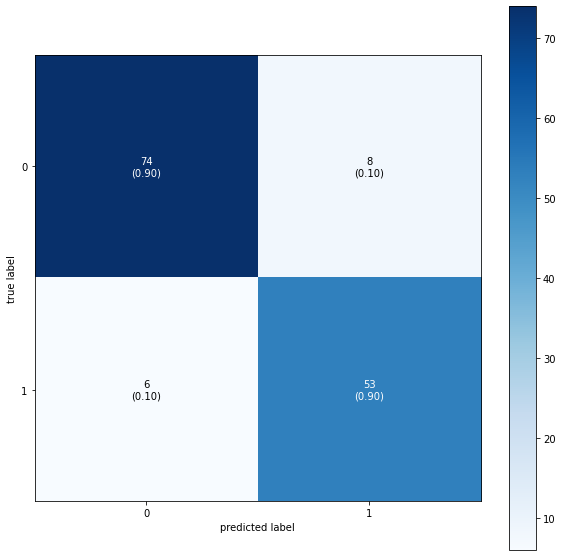

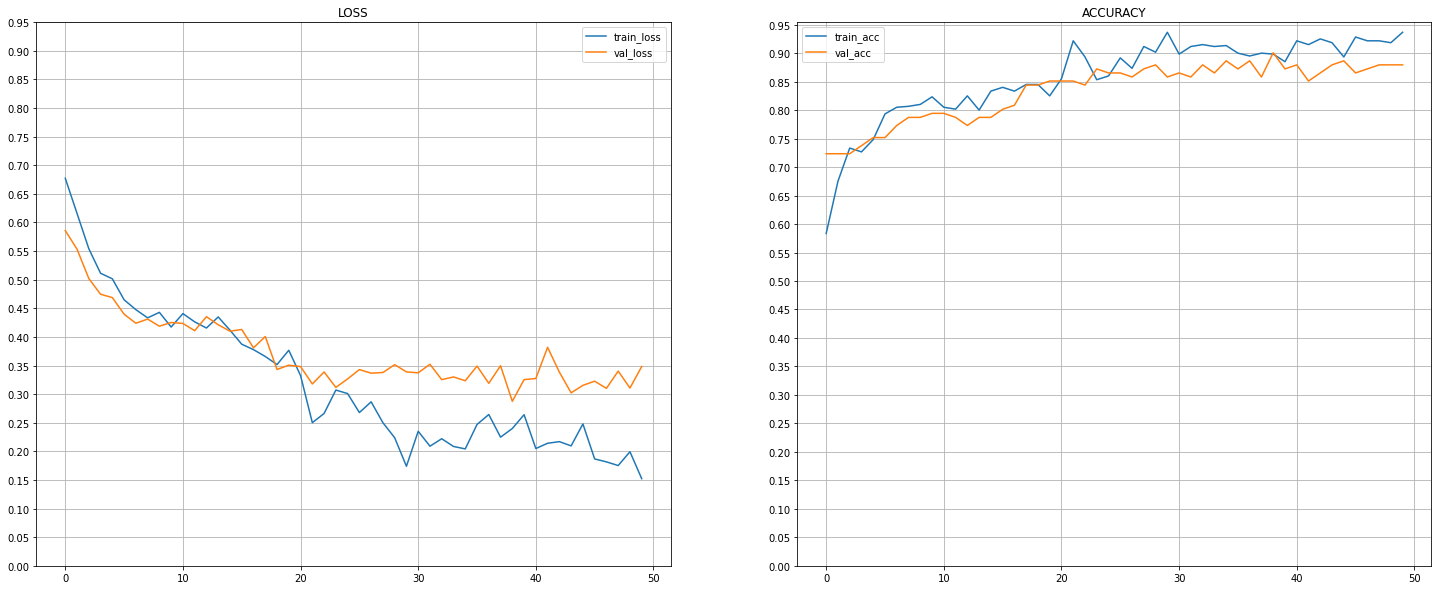

In [41]:
arr['4'] = train_model(model504 , criterion4 , optimizer4 , step_lr_scheduler4 , num_epochs=50)

#5

In [42]:
model_vgg165 = models.vgg16(pretrained=True)
model_vgg165.classifier[6].out_features = 2
model_vgg165 = model_vgg165.to(device)
#freeze convolution weights 
for param in model_vgg165.features.parameters():
  param.requires_grad = False


criterion5 = nn.CrossEntropyLoss()
optimizer5 = optim.SGD(model_vgg165.parameters(), lr=0.001)
step_lr_scheduler5 = lr_scheduler.CosineAnnealingLR(optimizer5 , T_max= 10 , eta_min=0)

Epoch 0/49
----------
train Loss: 2.6418 Acc: 0.5633
val Loss: 0.8724 Acc: 0.6383

Epoch 1/49
----------
train Loss: 0.7457 Acc: 0.7017
val Loss: 0.6942 Acc: 0.7021

Epoch 2/49
----------
train Loss: 0.5630 Acc: 0.7550
val Loss: 0.6281 Acc: 0.7092

Epoch 3/49
----------
train Loss: 0.5077 Acc: 0.7717
val Loss: 0.5528 Acc: 0.7447

Epoch 4/49
----------
train Loss: 0.4345 Acc: 0.8083
val Loss: 0.5538 Acc: 0.7234

Epoch 5/49
----------
train Loss: 0.4052 Acc: 0.8200
val Loss: 0.5099 Acc: 0.7589

Epoch 6/49
----------
train Loss: 0.3651 Acc: 0.8583
val Loss: 0.5080 Acc: 0.7730

Epoch 7/49
----------
train Loss: 0.3808 Acc: 0.8500
val Loss: 0.5062 Acc: 0.7447

Epoch 8/49
----------
train Loss: 0.3744 Acc: 0.8350
val Loss: 0.4978 Acc: 0.7660

Epoch 9/49
----------
train Loss: 0.3557 Acc: 0.8333
val Loss: 0.4966 Acc: 0.7660

Epoch 10/49
----------
train Loss: 0.3898 Acc: 0.8433
val Loss: 0.4966 Acc: 0.7660

Epoch 11/49
----------
train Loss: 0.3878 Acc: 0.8283
val Loss: 0.4966 Acc: 0.7660

Ep

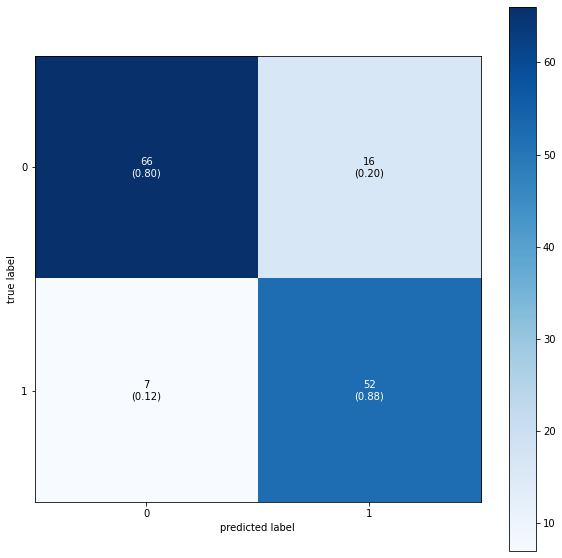

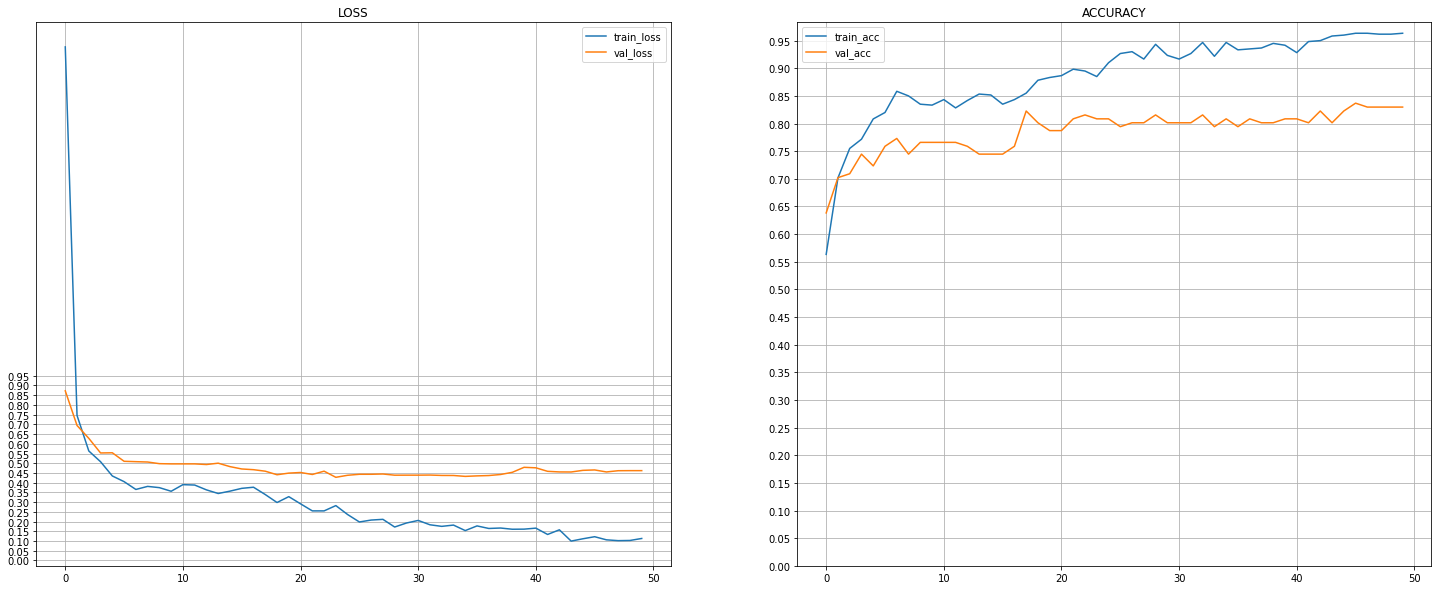

In [43]:
arr['5'] = train_model(model_vgg165 , criterion5 , optimizer5 , step_lr_scheduler5 , num_epochs=50)

#6

In [44]:
model186 = models.resnet18(pretrained=False)
num_ftrs = model186.fc.in_features
model183.fc = nn.Linear(num_ftrs , 2) 

model186 = model186.to(device)

criterion6 = nn.CrossEntropyLoss()
optimizer6 = optim.SGD(model186.parameters(), lr=0.001)
step_lr_scheduler6 = lr_scheduler.CosineAnnealingLR(optimizer6 , T_max= 10 , eta_min=0)

Epoch 0/49
----------
train Loss: 1.8047 Acc: 0.5033
val Loss: 0.7902 Acc: 0.4610

Epoch 1/49
----------
train Loss: 0.7352 Acc: 0.5317
val Loss: 0.6977 Acc: 0.5745

Epoch 2/49
----------
train Loss: 0.7110 Acc: 0.5450
val Loss: 0.6814 Acc: 0.5248

Epoch 3/49
----------
train Loss: 0.6912 Acc: 0.5800
val Loss: 0.6788 Acc: 0.5674

Epoch 4/49
----------
train Loss: 0.6968 Acc: 0.5667
val Loss: 0.6263 Acc: 0.7092

Epoch 5/49
----------
train Loss: 0.6860 Acc: 0.5783
val Loss: 0.6249 Acc: 0.6667

Epoch 6/49
----------
train Loss: 0.6770 Acc: 0.6000
val Loss: 0.6206 Acc: 0.6879

Epoch 7/49
----------
train Loss: 0.6647 Acc: 0.6033
val Loss: 0.6090 Acc: 0.7092

Epoch 8/49
----------
train Loss: 0.6623 Acc: 0.6283
val Loss: 0.6101 Acc: 0.6950

Epoch 9/49
----------
train Loss: 0.6748 Acc: 0.6100
val Loss: 0.6101 Acc: 0.7021

Epoch 10/49
----------
train Loss: 0.6641 Acc: 0.6350
val Loss: 0.6092 Acc: 0.6879

Epoch 11/49
----------
train Loss: 0.6669 Acc: 0.6017
val Loss: 0.6055 Acc: 0.7092

Ep

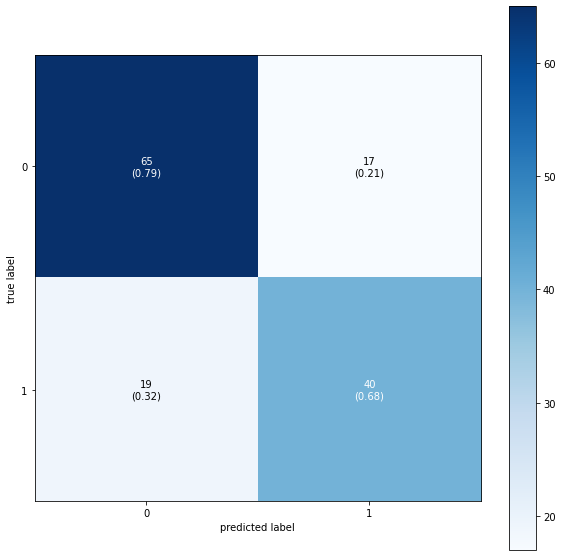

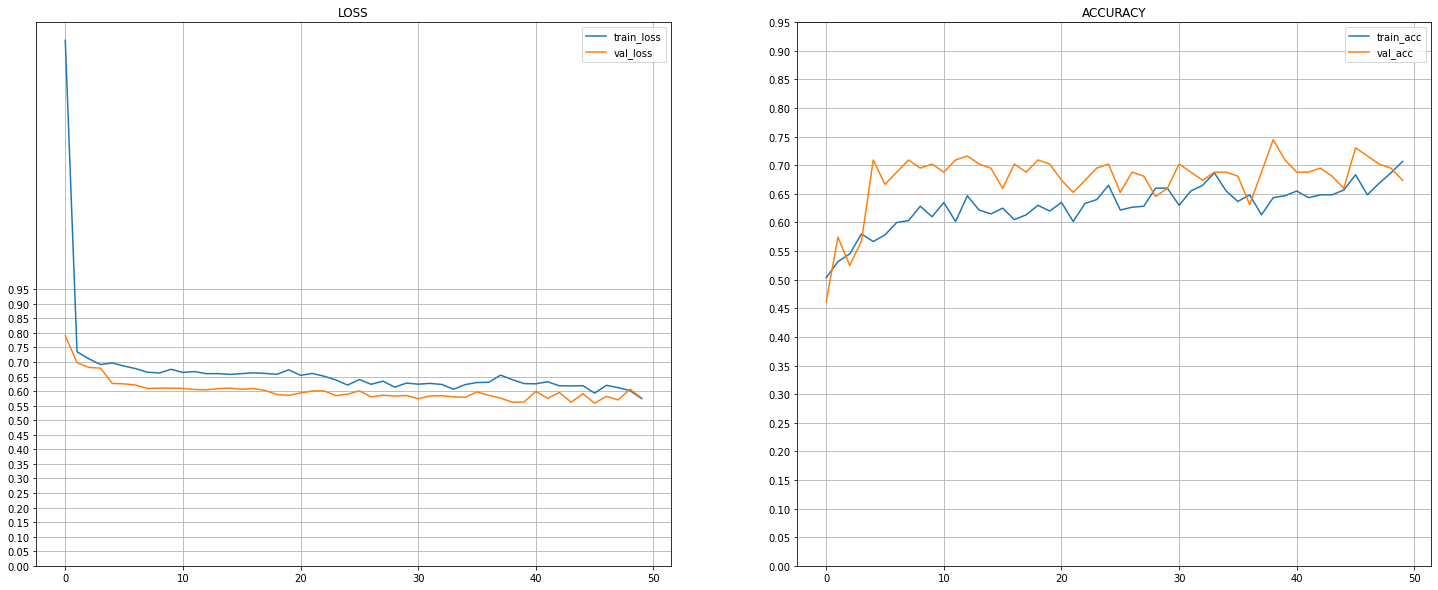

In [45]:
arr['6'] =train_model(model186 , criterion6 , optimizer6 , step_lr_scheduler6 , num_epochs=50)

#7

In [46]:
dataloader = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 32 , shuffle=True , num_workers=0),
    'val':torch.utils.data.DataLoader(image_datasets['val'], batch_size = 32 , shuffle=False , num_workers=0)
}

In [47]:
model187 = models.resnet18(pretrained=True)
num_ftrs = model187.fc.in_features
model187.fc = nn.Linear(num_ftrs , 2)

model187 = model187.to(device)

criterion7 = nn.CrossEntropyLoss()
optimizer7 = optim.SGD(model187.parameters(), lr=0.001)
step_lr_scheduler7 = lr_scheduler.CosineAnnealingLR(optimizer7 , T_max= 10 , eta_min=0)

Epoch 0/49
----------
train Loss: 0.7721 Acc: 0.4300
val Loss: 0.7694 Acc: 0.4397

Epoch 1/49
----------
train Loss: 0.7137 Acc: 0.5317
val Loss: 0.6980 Acc: 0.5674

Epoch 2/49
----------
train Loss: 0.6720 Acc: 0.6000
val Loss: 0.6780 Acc: 0.5674

Epoch 3/49
----------
train Loss: 0.6528 Acc: 0.6200
val Loss: 0.6540 Acc: 0.6099

Epoch 4/49
----------
train Loss: 0.6266 Acc: 0.6517
val Loss: 0.6390 Acc: 0.6099

Epoch 5/49
----------
train Loss: 0.5999 Acc: 0.6983
val Loss: 0.6269 Acc: 0.6312

Epoch 6/49
----------
train Loss: 0.5976 Acc: 0.6917
val Loss: 0.6174 Acc: 0.6454

Epoch 7/49
----------
train Loss: 0.5890 Acc: 0.6967
val Loss: 0.6135 Acc: 0.6525

Epoch 8/49
----------
train Loss: 0.5760 Acc: 0.7350
val Loss: 0.6089 Acc: 0.6596

Epoch 9/49
----------
train Loss: 0.5806 Acc: 0.7217
val Loss: 0.6114 Acc: 0.6667

Epoch 10/49
----------
train Loss: 0.5804 Acc: 0.7067
val Loss: 0.6115 Acc: 0.6525

Epoch 11/49
----------
train Loss: 0.5759 Acc: 0.7267
val Loss: 0.6118 Acc: 0.6596

Ep

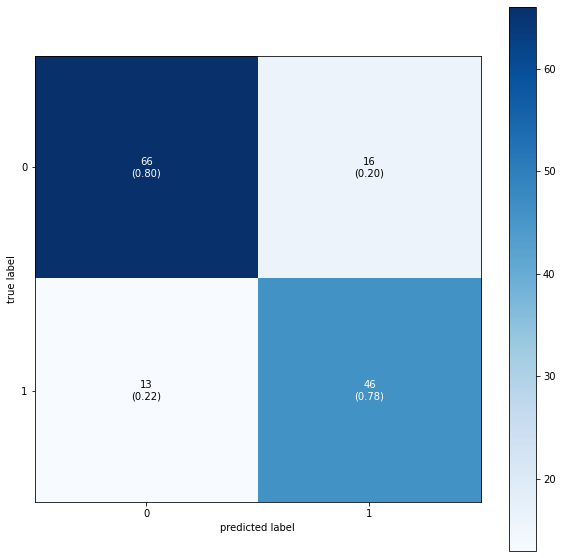

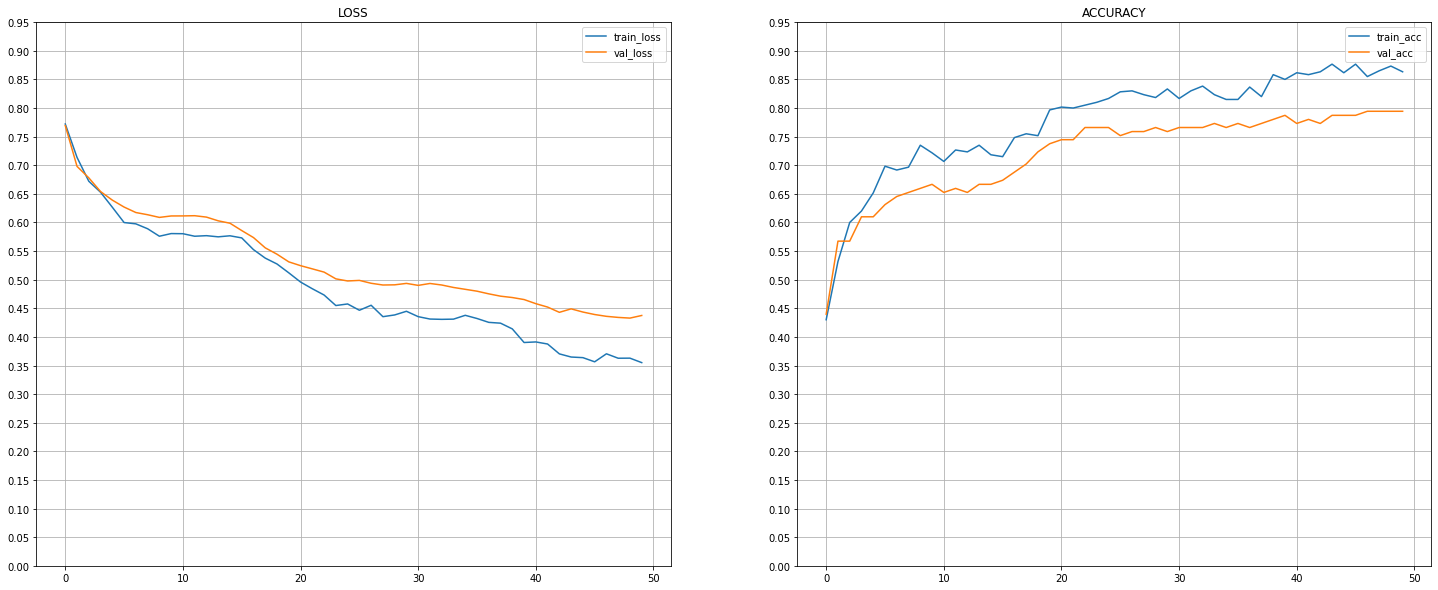

In [48]:
arr['7'] = train_model(model187 , criterion7 , optimizer7 , step_lr_scheduler7 , num_epochs=50)

#8

In [49]:
# new_path = '/content/gdrive/MyDrive/JCE/ysom/End Project/new_archive'
new_path ='/content/gdrive/MyDrive/yesom project/new_archive'
#import the dataset from the folders
image_datasets = {
    'train': torchvision.datasets.ImageFolder(new_path+'/walk_or_run_train/train' ,data_transforms['train'] ),
    'val':torchvision.datasets.ImageFolder(new_path+'/walk_or_run_test/test',data_transforms['val'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 755, 'val': 134}


In [50]:
# init the loader
dataloader = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 4 , shuffle=True , num_workers=0),
    'val':torch.utils.data.DataLoader(image_datasets['val'], batch_size = 4 , shuffle=False , num_workers=0)
}


755


<BarContainer object of 2 artists>

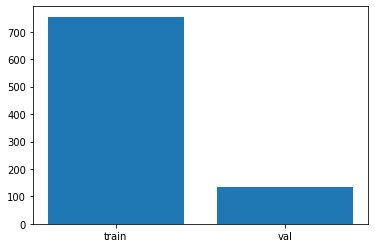

In [51]:
#data size plot
print(dataset_sizes['train'])
plt.bar(*zip(*dataset_sizes.items()))

{'run': 402, 'walk': 353}


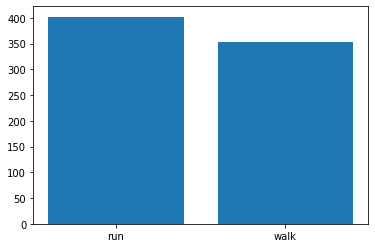

In [52]:
temp_dict ={'run':0 , 'walk':0} 
for x in range(dataset_sizes['train']):
  if image_datasets['train'][x][1] == 0:
    temp_dict['run']+=1
  else:
    temp_dict['walk']+=1
    
plt.bar(*zip(*temp_dict.items()))

print(temp_dict)

In [53]:
model188 = models.resnet18(pretrained=True)
num_ftrs = model188.fc.in_features
model188.fc = nn.Linear(num_ftrs , 2)

model188 = model188.to(device)

criterion8 = nn.CrossEntropyLoss()
optimizer8 = optim.Adam(model188.parameters(), lr=0.001)
step_lr_scheduler8 = lr_scheduler.CosineAnnealingLR(optimizer8 , T_max= 10 , eta_min=0)

Epoch 0/49
----------
train Loss: 0.8444 Acc: 0.5351
val Loss: 0.7923 Acc: 0.5299

Epoch 1/49
----------
train Loss: 0.7329 Acc: 0.5364
val Loss: 0.6133 Acc: 0.6716

Epoch 2/49
----------
train Loss: 0.7031 Acc: 0.5603
val Loss: 0.7690 Acc: 0.6119

Epoch 3/49
----------
train Loss: 0.6980 Acc: 0.5536
val Loss: 0.7827 Acc: 0.7164

Epoch 4/49
----------
train Loss: 0.6702 Acc: 0.6212
val Loss: 0.5710 Acc: 0.6791

Epoch 5/49
----------
train Loss: 0.6284 Acc: 0.6596
val Loss: 0.7170 Acc: 0.5896

Epoch 6/49
----------
train Loss: 0.6215 Acc: 0.6543
val Loss: 0.6535 Acc: 0.6791

Epoch 7/49
----------
train Loss: 0.6062 Acc: 0.6623
val Loss: 0.6203 Acc: 0.5970

Epoch 8/49
----------
train Loss: 0.5900 Acc: 0.6874
val Loss: 0.5061 Acc: 0.7239

Epoch 9/49
----------
train Loss: 0.5862 Acc: 0.7073
val Loss: 0.4989 Acc: 0.7761

Epoch 10/49
----------
train Loss: 0.5578 Acc: 0.7139
val Loss: 0.4997 Acc: 0.7388

Epoch 11/49
----------
train Loss: 0.5775 Acc: 0.7020
val Loss: 0.5092 Acc: 0.7537

Ep

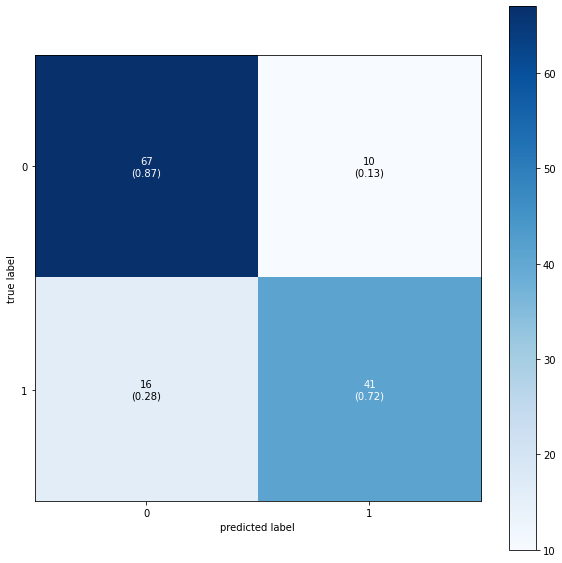

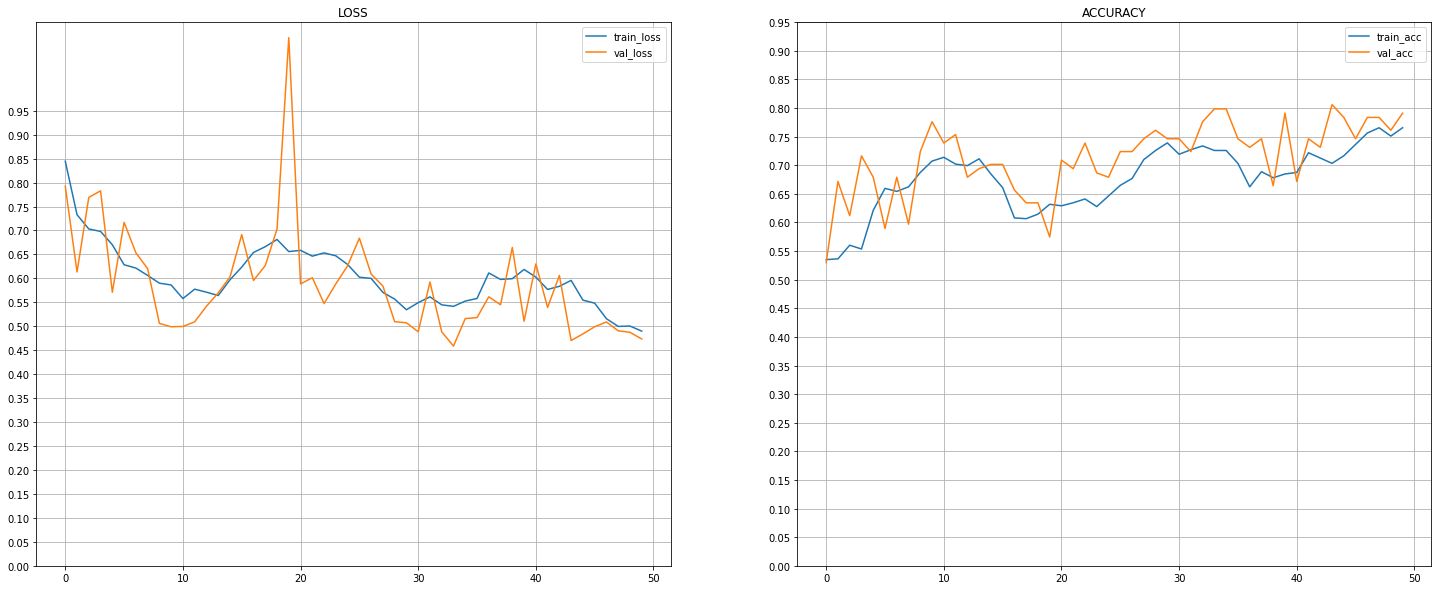

In [54]:
arr['8'] = train_model(model188 , criterion8 , optimizer8 , step_lr_scheduler8 , num_epochs=50)